In [1]:
# import libraries
import requests
from requests.exceptions import RequestException
from urllib.request import urlopen, quote

from bs4 import BeautifulSoup
import json

import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors



import requests, csv # library to handle requests
# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium
# !conda install scikit-learn
# !pip install -U scikit-learn
from sklearn.cluster import KMeans


print('Libraries imported')

Libraries imported


### Use BeautifulSoup and requests to crawl the data from target website

In [ ]:
# import some libraries we need
import requests
from requests.exceptions import RequestException
from multiprocessing import Pool
import json
from bs4 import BeautifulSoup


# Build fuction to crawl one page
def get_one_page(url):
    # use try to check if cnnection is good and is not blocked by the target website
    try:
        response = requests.get(url)
        if response.status_code == 200: # statuscode=200 all good
            return response.text # return text formart
        return None
    except RequestException:
        return None

#Build function to parse one page and use 'lxml' to extract the source code
def parse_one_page(html):
    soup = BeautifulSoup(html, features="lxml")
    # after analysis, our inforamtiton are stored under tag 'li' and the class=resblock-list post_ulog_exposure_scroll has-results'
    results = soup.findAll('li', class_='resblock-list post_ulog_exposure_scroll has-results')
    
    # Empty list to contain the data
    information = []
    for result in results:
        # extract the actually data we need
        name = result.find('a', class_='name').text
        location = result.find('a', class_='resblock-location').text[1:-3].replace('/', '')
        price = result.find('span', class_='number').text
        information.append((name, location, price))
    for item in information:
        # use yield so that 'parse_one_page(html)' can be iteriable
        yield {
            'name': item[0],
            'location': item[1],
            'price': item[2]
        }

# build fucton to save content into a csv file so that we can easily read it into pandas
def write_to_file(content):
    with open('wuxi.csv', 'a', encoding='utf-8') as f:
        f.write(json.dumps(content, ensure_ascii=False) + '\n')
        f.close()

# Main funtion
def main(num):
    # through analysis, we can get the url of the target website is made by 'https://wx.fang.ke.com/loupan/'pa+(1-65)
    url = 'https://wx.fang.ke.com/loupan/pg' + str(num)
    html = get_one_page(url)
    for item in parse_one_page(html):
        print(item)
        write_to_file(item)

    # for items in parse_one_page(html):
    #     print((items))


if __name__ == '__main__':
    pool = Pool()
    pool.map(main, [i for i in range(1, 66)])

### Some background info,  generally we have three types of real estate in China: Business apartment, General Apartment and House, and all of these we can only have rights to live instead of the ownership. please refer to https://en.wikipedia.org/wiki/Land_reforms_by_country#China if you have any questions.
### Columns description:
1. Name: Apartment name which named by the Real estate companies of China
2. Address: The address of which apartments are located
3. Price: The average selling price of apartments 

In [2]:
# I have already removed the keys before
columns = ['Name', 'Address', 'Price']
data_raw = pd.read_csv('wuxi_property.csv', names=columns)
data_raw.head()

,Name,Address,Price
0,无锡市无锡中关村科技创新园,新吴硕放太科园干城路6号（环太湖高速公路新安出口与312国道交叉处）,5500
1,无锡市第一上海广场,宜兴市宜兴绿园路恒峰线缆对面,价格待定
2,无锡市中凯润投资硕放项目,新吴硕放高浪东路19号（高浪路与锡士路交汇处，新区教堂南侧）,价格待定
3,无锡市中锦城硕放项目,新吴硕放薛典路东侧，经一路西侧,价格待定
4,无锡市星富广场,新吴硕放薛典路东侧、经一路西侧,价格待定


### I have already collected the  Latitude and Longitude information for our data

In [3]:
location_raw = pd.read_csv('wuxi_location.csv')
location_raw.head()

,Name,Latitude,Longitude
0,无锡市无锡中关村科技创新园,31.455300,120.416369
1,无锡市第一上海广场,31.529088,120.386416
2,无锡市中凯润投资硕放项目,31.494278,120.457621
3,无锡市中锦城硕放项目,0.000000,0.000000
4,无锡市星富广场,31.627862,120.303914


### Merge these two dataframe into Dataframe data

In [4]:
location_raws = location_raw.drop_duplicates()
data = location_raws.merge(data_raw)
data.head(10)

,Name,Latitude,Longitude,Address,Price
0,无锡市无锡中关村科技创新园,31.455300,120.416369,新吴硕放太科园干城路6号（环太湖高速公路新安出口与312国道交叉处）,5500
1,无锡市第一上海广场,31.529088,120.386416,宜兴市宜兴绿园路恒峰线缆对面,价格待定
2,无锡市中凯润投资硕放项目,31.494278,120.457621,新吴硕放高浪东路19号（高浪路与锡士路交汇处，新区教堂南侧）,价格待定
3,无锡市中锦城硕放项目,0.000000,0.000000,新吴硕放薛典路东侧，经一路西侧,价格待定
4,无锡市星富广场,31.627862,120.303914,新吴硕放薛典路东侧、经一路西侧,价格待定
5,无锡市新太阳房产阳山项目,0.000000,0.000000,惠山堰桥林新路2号,价格待定
6,无锡市金汇熙园,31.354604,119.787982,惠山堰桥东至阳山镇派出所，南至环山路,价格待定
7,无锡市金汇熙园,31.354604,119.787982,宜兴市宜兴绿园路恒峰线缆对面,11000
8,无锡市景湖天成,31.369522,119.789696,宜兴市宜兴东临宜园，南至氿南路，西至新长铁路宜兴城区段，北至西氿,14000
9,无锡市景湖天成,31.369522,119.789696,宜兴市宜兴东临宜园，南至氿南路，西至新长铁路宜兴城区段，北至西氿,14000


### Based on the following, there are some same "Names" or/and "Addresses" with difference prices, that's beacuse sometimes we have houses and apartments built by the same business developer

#### So I'm going to fill the "价格待定" which means 'unknow' value with the mean of all the price. 
#### And at the same time, to remove the 'dirty' rows as well as the price which are clearly mistake such as '300' in 266 against the normal

In [5]:
df = data.loc[data['Price']!='价格待定']
df['Price'] = df['Price'].astype(str).astype(int).astype(float)
print(df.head())
print(df.dtypes)

             Name   Latitude   Longitude                             Address  \
0   无锡市无锡中关村科技创新园  31.455300  120.416369  新吴硕放太科园干城路6号（环太湖高速公路新安出口与312国道交叉处）   
7         无锡市金汇熙园  31.354604  119.787982                      宜兴市宜兴绿园路恒峰线缆对面   
8         无锡市景湖天成  31.369522  119.789696    宜兴市宜兴东临宜园，南至氿南路，西至新长铁路宜兴城区段，北至西氿   
9         无锡市景湖天成  31.369522  119.789696    宜兴市宜兴东临宜园，南至氿南路，西至新长铁路宜兴城区段，北至西氿   
10        无锡市景湖天成  31.369522  119.789696                江阴市江阴南闸街道金三角路与紫金路交汇处   

      Price  
0    5500.0  
7   11000.0  
8   14000.0  
9   14000.0  
10   9500.0  
Name          object
Latitude     float64
Longitude    float64
Address       object
Price        float64
dtype: object


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
df = df.loc[df['Price']>4000].sort_values('Price')

df.describe()

,Latitude,Longitude,Price
count,414.000000,414.000000,414.000000
mean,30.487411,116.210035,15972.516908
std,5.711357,21.767877,6869.592664
min,0.000000,0.000000,5500.000000
25%,31.491967,120.228851,11000.000000
50%,31.559675,120.305054,14950.000000
75%,31.605990,120.367391,20000.000000
max,31.891073,120.570329,60000.000000


### The mean of the Price is about 15972.5. So to make our project success, I'm going to fill the mean value to the value '价格未定'

In [7]:
# assign Price == ‘价格未定 to DataFrame dfs
dfs = data.loc[data['Price']=='价格待定']
dfs['Price']=15972.5

dfs.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Name,Latitude,Longitude,Address,Price
1,无锡市第一上海广场,31.529088,120.386416,宜兴市宜兴绿园路恒峰线缆对面,15972.5
2,无锡市中凯润投资硕放项目,31.494278,120.457621,新吴硕放高浪东路19号（高浪路与锡士路交汇处，新区教堂南侧）,15972.5
3,无锡市中锦城硕放项目,0.000000,0.000000,新吴硕放薛典路东侧，经一路西侧,15972.5
4,无锡市星富广场,31.627862,120.303914,新吴硕放薛典路东侧、经一路西侧,15972.5
5,无锡市新太阳房产阳山项目,0.000000,0.000000,惠山堰桥林新路2号,15972.5


In [8]:
Data = df.append(dfs, ignore_index=True)
Data = Data.sort_values(by=['Name']).reset_index(drop=True)
Data = Data.drop_duplicates(subset='Name', keep='first')

Data.head()

,Name,Latitude,Longitude,Address,Price
0,无锡市IN立方创新空间,0.000000,0.000000,锡山东北塘芙蓉六路8号,15972.5
1,无锡市ΜΟΜΛ春风湖上,31.525052,120.560900,锡山鹅湖鹅湖镇景园路东、望湖路北、新园桥路南,11500.0
3,无锡市万业观山泓郡,31.598026,120.448155,锡山安镇东翔路1509号,18000.0
5,无锡市万健广场,31.613114,120.215703,惠山钱桥盛岸西路与新业大道交叉口,16000.0
6,无锡市万庭嘉融域,31.381076,119.868267,宜兴市宜兴庆源大道北侧，东氿大道东侧,15972.5


### 2. The next step is to add the Latitude and Longitude informations for each in location, I tried to use FourSquare API but ...in China
### As we can see the addreess are not completly, to increase the rate of success, I'm going to use the Names as the address in maps to get each Latitude and Longitude information. And at the same time, I'll add the city name"无锡市"to each name.

### Some building are not shown on the map and I'll remove them go get a better result(because thay are being planned)

In [9]:
Data_map = Data.loc[Data['Latitude']!=0]
Data_map.reset_index(inplace=True, drop=True)
Data_map.head(10)

,Name,Latitude,Longitude,Address,Price
0,无锡市ΜΟΜΛ春风湖上,31.525052,120.560900,锡山鹅湖鹅湖镇景园路东、望湖路北、新园桥路南,11500.0
1,无锡市万业观山泓郡,31.598026,120.448155,锡山安镇东翔路1509号,18000.0
2,无锡市万健广场,31.613114,120.215703,惠山钱桥盛岸西路与新业大道交叉口,16000.0
3,无锡市万庭嘉融域,31.381076,119.868267,宜兴市宜兴庆源大道北侧，东氿大道东侧,15972.5
4,无锡市万科信成道,31.494197,120.297964,滨湖海岸城市民中心信成道高浪路交汇处（观顺道西侧）,25000.0
5,无锡市万科北门塘上,31.614681,120.294482,梁溪黄巷广石西路与凤宾路交叉口西南侧,17500.0
6,无锡市万科吴都路地块,31.484508,120.290816,滨湖塘铁桥吴都路万科吴都路地块,15972.5
7,无锡市万科天一新著,31.648087,120.305770,惠山西漳惠山天锦路和凤鸣路交汇,16000.0
8,无锡市万科天一玖著,31.646859,120.304601,惠山西漳天昌路南侧、凤鸣路西侧,17000.0
9,无锡市万科新酩悦,31.496509,120.286860,滨湖万象城东绛万顺路与大通路交叉口,23000.0


In [10]:
print('The dataframe has {} apartments we can choose to buy.'.format(len(Data_map)))

The dataframe has 414 apartments we can choose to buy.


### Use Baidu API to generate the latitude and longitude values of Wuxi City

In [11]:
ADDRESS = '江苏省无锡市'
OUTPUT = 'json'
AK = 'E5P6XM7eDQcQLioeHcmnXontS6c0g9TF'

url = 'http://api.map.baidu.com/geocoder/v2/?address={}&output={}&ak={}'.format(quote(ADDRESS), OUTPUT, AK)
        

results = requests.get(url).json()

latitude = results['result']['location']['lat']
longitude = results['result']['location']['lng']
print('Address: '+ ADDRESS)
print('The geograpical coordinate of Wuxi City are {}, {}.'.format(latitude, longitude))


Address: 江苏省无锡市
The geograpical coordinate of Wuxi City are 31.498809732685714, 120.31858328810601.


In [12]:
# create map of Wuxi using latitude and longitude values
map_wuxi = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers to map
for lat, lng, apartment in zip(Data_map['Latitude'], Data_map['Longitude'], Data_map['Name']):
    label = '{}'.format(apartment)
    folium.Marker(location=[lat,lng],
                  popup=label,
                  icon=folium.Icon(color='green',prefix='fa',icon='circle')).add_to(map_wuxi)

#   
map_wuxi

In [13]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.2


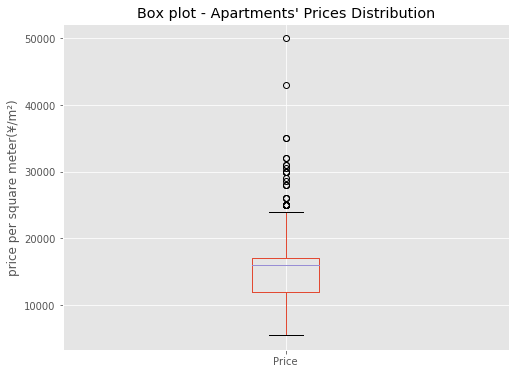

In [14]:
df_box = Data_map[['Price']]

df_box.plot(kind='box', figsize=(8, 6))

plt.title("Box plot - Apartments' Prices Distribution")
plt.ylabel('price per square meter(¥/m²)')

plt.show()

In [15]:
import numpy as np

A histogram is a way of representing the frequency distribution of numeric dataset. The way it works is it partitions the x-axis into bins, assigns each data point in our dataset to a bin, and then counts the number of data points that have been assigned to each bin. So the y-axis is the frequency or the number of data points in each bin. Note that we can change the bin size and usually one needs to tweak it so that the distribution is displayed nicely.
Question: What is the frequency distribution of the number (population) of new immigrants from the various countries to Canada in 2013?
Before we proceed with creating the histogram plot, let's first examine the data split into intervals. To do this, we will us Numpy's histrogram method to get the bin ranges and frequency counts as follows:

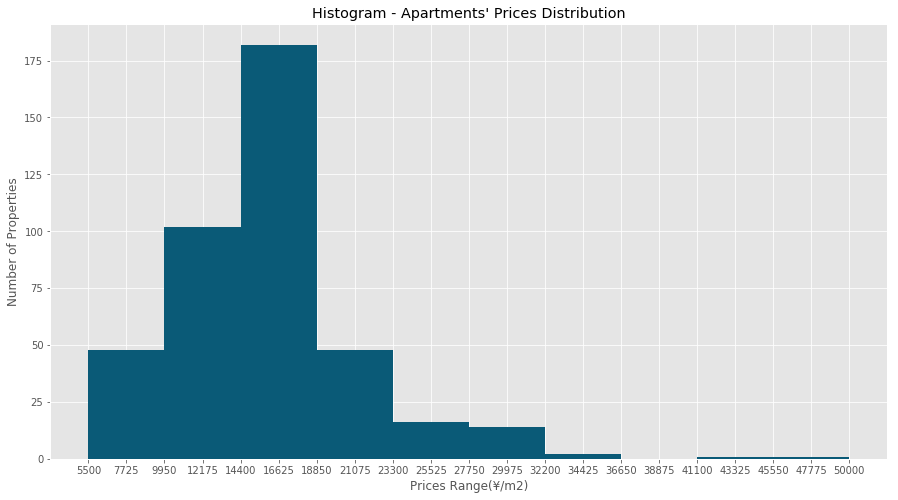

In [16]:
# 'bin_edges' is a list of bin intervals
count, bin_edges = np.histogram(df_box['Price'], 20)

df_box['Price'].plot(
    kind='hist',
    figsize=(15, 8),
    xticks=bin_edges,
    color=['#0a5a77', 'darkslateblue', 'mediumseagreen'])

#     color=['coral', 'darkslateblue', 'mediumseagreen'])

plt.title("Histogram - Apartments' Prices Distribution") # add a title to the histogram
plt.xlabel('Prices Range(¥/m2)') # add y-label
plt.ylabel('Number of Properties') # add x-label

plt.show()

In [17]:
df_clean = Data_map.loc[Data_map['Price']>14000].sort_values('Price')
df_clean = df_clean.loc[df_clean['Price']<18000].sort_values('Price')

print(df_clean.describe())
df_clean.reset_index(drop=True, inplace=True)

         Latitude   Longitude         Price
count  166.000000  166.000000    166.000000
mean    31.554638  120.282440  15972.454819
std      0.099042    0.166613    508.199695
min     31.268468  119.639533  14500.000000
25%     31.497850  120.272760  15972.500000
50%     31.559029  120.305448  15972.500000
75%     31.602453  120.362931  15972.500000
max     31.926075  120.570329  17500.000000


In [18]:
df_clean.head(10)

,Name,Latitude,Longitude,Address,Price
0,无锡市华夏世纪锦园南区,31.625473,120.477896,锡山安镇锡东大道与胶阳路交汇处,14500.0
1,无锡市中南君悦府,31.466526,120.444062,新吴硕放新吴区空港产业园环太湖高速公路南侧、通祥路西侧,14500.0
2,无锡市康诗丹郡,31.577184,120.346260,梁溪上马墩广源路1号,14800.0
3,无锡市家乐府,31.557940,120.305213,梁溪黄巷永乐路380号（清扬路与永乐路交汇处，家乐福旁）,14900.0
4,无锡市龙湖天鉅,31.689207,120.311438,惠山堰桥惠源路龙湖天鉅项目,15000.0
5,无锡市万科维园,31.551629,120.428051,新吴梅村锡义路与梅西路交汇处,15000.0
6,无锡市恒大珺睿府,31.374403,119.874300,宜兴市宜兴庆源大道与东氿大道交汇处往东300米,15000.0
7,无锡市绿地观澜湾,31.579739,120.294026,梁溪北大街县前西街与解放西路交叉口西北侧,15000.0
8,无锡市家乐苑,31.557940,120.305213,梁溪清名桥清扬路与永乐路交汇处永乐路380号,15000.0
9,无锡市阳光100国际新城北区,31.644368,120.284248,惠山西漳阳光100国际新城,15000.0


In [19]:
# create map of Wuxi using latitude and longitude values
map_clean = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers to map
for lat, lng, apartment in zip(df_clean['Latitude'], df_clean['Longitude'], df_clean['Name']):
    label = '{}'.format(apartment)
    folium.Marker(location=[lat,lng],
                  popup=label,
                  icon=folium.Icon(color='red',prefix='fa',icon='circle')).add_to(map_clean)

#   
map_clean

#### So next we need to think about what we are concidering when we are trying to buy house or apartment: The price factor of course, are there any hospitals or schools nearby?
#### By search online, people generally will concider the following factors and here we call them features: 
##### Parks,
##### Supermarkets,
##### Restaurants,
##### Schools,
##### Hospitals,
##### Bus Stop,
##### Banks(ATM),
##### Theaters

#### What I'm going to do now is to seach each item in Data_map dataframe with these features. And I'll use Baidu API to achieve that and I'll use keywords in Chinese to proceed.
##### Let's explore the first apartment in the dataframe to check the outcome

In [20]:
df_clean.loc[:,'Name']

0         无锡市华夏世纪锦园南区
1            无锡市中南君悦府
2             无锡市康诗丹郡
3              无锡市家乐府
4             无锡市龙湖天鉅
5             无锡市万科维园
6            无锡市恒大珺睿府
7            无锡市绿地观澜湾
8              无锡市家乐苑
9      无锡市阳光100国际新城北区
10              无锡市圣园
11            无锡市时代国际
12          无锡市中海凤凰熙岸
13     无锡市阳光100国际新城商铺
14            无锡市金桂尚苑
15          无锡市茂业时代广场
16             无锡市乙画苑
17              无锡市鸿墅
18            无锡市水岸名府
19          无锡市观山名筑南区
20         无锡市龙世西湖湾庄园
21          无锡市龙湖九墅天玺
22       无锡市中国宜兴国际环保城
23           无锡市万庭嘉融域
24           无锡市龙湖紫云台
25         无锡市陶里文化商业街
26            无锡市龙湖天璞
27          无锡市龙湖天宸原著
28          无锡市万科观湖礼著
29          无锡市龙湖九里晴川
            ...      
136         无锡市港龙财智国际
137        无锡市港下红豆万花城
138         无锡市翠竹芙蓉山庄
139       无锡市保利融侨时光印象
140         无锡市恒威中央领地
141          无锡市阿维侬庄园
142          无锡市华润江南府
143         无锡市美的公园天下
144         无锡市万科天一新著
145         无锡市万科金域缇香
146           无锡市万健广场
147            无锡市玉麒会
148      无锡市启迪协信·梁溪本源
149          无锡市美的国宾府
150       

In [21]:
first_latitude = df_clean.loc[0, 'Latitude'] 
first_longitude = df_clean.loc[0, 'Longitude']

first_name = df_clean.loc[0, 'Name']

print('Latitude and longitude values of {} are {}, {}.'.format(first_name, 
                                                               first_latitude, 
                                                               first_longitude))

Latitude and longitude values of 无锡市华夏世纪锦园南区 are 31.62547257, 120.4778955.


#### Now, let's get the top features around 无锡市华夏世纪锦园南区 within a radius of 1000 meters.

In [22]:
QUERY = '公园$超市$美食$学校$医院$公交车站$银行$电影院'
location = 'first_latitude, first_longitude'
raduis = 1000
OUTPUT = 'json'
AK = 'Zg9Qloj9Bf21LYL0fck9N8xhjQXZoHgn'

# 'page_size=20' means the muxium results on the page is 20
url_page1 = 'http://api.map.baidu.com/place/v2/search?\
query={}&location={},{}&radius={}&output={}&scope=2&page_size=20&page_num={}&ak={}'.format(
QUERY,
first_latitude,
first_longitude,
raduis,
OUTPUT,
0,
AK
)
url_page1

'http://api.map.baidu.com/place/v2/search?query=公园$超市$美食$学校$医院$公交车站$银行$电影院&location=31.62547257,120.4778955&radius=1000&output=json&scope=2&page_size=20&page_num=0&ak=Zg9Qloj9Bf21LYL0fck9N8xhjQXZoHgn'

### Because of the Baidu API, all the results displayed by pages and I'll limit the result under 100 which means the max value of page_num is 4.

In [23]:
url_list = []
for num in range(0, 5):
    urls = 'http://api.map.baidu.com/place/v2/search?query=公园$超市$美食$学校$医院$公交车站$银行$电影院\
    &location={},{}&radius=1000&output=json&scope=2&page_size=20\
    &page_num={}&ak=E5P6XM7eDQcQLioeHcmnXontS6c0g9TF'.format(
    first_latitude,
    first_longitude,
    num)
    url_list.append(urls)

In [24]:
url_list

['http://api.map.baidu.com/place/v2/search?query=公园$超市$美食$学校$医院$公交车站$银行$电影院    &location=31.62547257,120.4778955&radius=1000&output=json&scope=2&page_size=20    &page_num=0&ak=E5P6XM7eDQcQLioeHcmnXontS6c0g9TF',
 'http://api.map.baidu.com/place/v2/search?query=公园$超市$美食$学校$医院$公交车站$银行$电影院    &location=31.62547257,120.4778955&radius=1000&output=json&scope=2&page_size=20    &page_num=1&ak=E5P6XM7eDQcQLioeHcmnXontS6c0g9TF',
 'http://api.map.baidu.com/place/v2/search?query=公园$超市$美食$学校$医院$公交车站$银行$电影院    &location=31.62547257,120.4778955&radius=1000&output=json&scope=2&page_size=20    &page_num=2&ak=E5P6XM7eDQcQLioeHcmnXontS6c0g9TF',
 'http://api.map.baidu.com/place/v2/search?query=公园$超市$美食$学校$医院$公交车站$银行$电影院    &location=31.62547257,120.4778955&radius=1000&output=json&scope=2&page_size=20    &page_num=3&ak=E5P6XM7eDQcQLioeHcmnXontS6c0g9TF',
 'http://api.map.baidu.com/place/v2/search?query=公园$超市$美食$学校$医院$公交车站$银行$电影院    &location=31.62547257,120.4778955&radius=1000&output=json&scope=2&page_size=2

In [25]:
results_json_list = []
for each in url_list:
    results_json = requests.get(each).json()['results']
    results_json_list.append(results_json)

In [26]:
# create columns for nearby_verues_details
filtered_columns = ['name', 'detail_info.type', 'location.lat', 'location.lng'] 
# create an empty dataframe called nearby_venues
nearby_venues_details = pd.DataFrame() 


In [27]:
for each_item in results_json_list: # results_json_listvenues_list contains all the venues found of one apartment
    venues_pd = json_normalize(each_item) # flattenjson file
    nearby_venues_details = nearby_venues_details.append(venues_pd, sort=False) # merge these dataframe into one dataframe

# extract data under the columns only
nearby_venues_details =nearby_venues_details.loc[:, filtered_columns] 
nearby_venues_details.reset_index(inplace=True, drop=True)

# Rename column names
nearby_venues_details.rename(columns={'name':'Name', 'detail_info.type':'Categories',
                              'location.lat':'Latitude', 'location.lng':'Longitude'}, inplace=True)
print(len(nearby_venues_details))
nearby_venues_details.head(10)

55


,Name,Categories,Latitude,Longitude
0,和泽公园,scope,31.622816,120.484799
1,世纪华联超市(安镇店),shopping,31.620017,120.480681
2,建也百货店,shopping,31.623679,120.484248
3,春琴百货店,shopping,31.619996,120.483942
4,每天惠便利店,shopping,31.629997,120.484912
5,易捷便利店(胶山店),shopping,31.626023,120.481490
6,庆友百货,shopping,31.624404,120.482635
7,烟酒超市,shopping,31.620004,120.483812
8,便利超市,shopping,31.619812,120.478040
9,苏泰百货超市,shopping,31.618805,120.481588


In [28]:
print('{} venues returned.'.format(nearby_venues_details.shape[0]))

55 venues returned.


### Now it's time to use function to do the same thing with every apartments in dataframe Data_map

In [29]:
def get_nearby_venues(names, prices, latitudes, longitudes):
    venues_list=[]
    
    for name, price, lat, lng in zip(names, prices, latitudes, longitudes):
        print(name)

        # construct urls from page 1 to page 5, limit the venues under 100 of each apartment
        url_list=[]
        for num in range(0, 5):
            urls = 'http://api.map.baidu.com/place/v2/search?query=公园$超市$美食$学校$医院$公交车站$银行$电影院\
            &location={},{}&radius=1000&output=json&scope=2&page_size=20\
            &page_num={}&ak=E5P6XM7eDQcQLioeHcmnXontS6c0g9TF'.format(
                lat, 
                lng,
                num)
            url_list.append(urls)

        # make request to get json content
        results_json_list=[]
        for url in url_list:
            results_json = requests.get(url).json()['results']
            # merge all pages json content into one json file
            results_json_list.extend(results_json)
        
        # return only relevant information for each nearby venue
        for v in results_json_list:
            # set exception in case the value of ['tag']==None
            try:
                venues_list.append([(
                    name,
                    price,
                    lat, 
                    lng, 
                    v['name'], 
                    v['location']['lat'], 
                    v['location']['lng'],  
                    v['detail_info']['tag'] if not None else 'NaN')])
            except KeyError:
                pass

    # convert into dataframe
    nearby_venues = pd.DataFrame([item for sublist in venues_list for item in sublist])
    
    # assign columns for dataframe
    nearby_venues.columns = ['Apartment', 
                             'Apartment Price',
                             'Apartment Latitude', 
                             'Apartment Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category'] 

    return(nearby_venues)

In [ ]:
data_venues = get_nearby_venues(names=df_clean['Name'],
                                prices=df_clean['Price'],
                                latitudes=df_clean['Latitude'],
                                longitudes=df_clean['Longitude']
                               )

In [ ]:
data_venues.to_csv("wx_apartments.csv", index=False)

### Check the size of the new dataframe with every venue associated.

In [31]:
df_venues=pd.read_csv('wx_apartments.csv')
print(df_venues.shape)
df_venues.head()

(10733, 8)


,Apartment,Apartment Price,Apartment Latitude,Apartment Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,无锡市华夏世纪锦园南区,14500.0,31.625473,120.477896,和泽公园,31.622816,120.484799,旅游景点;公园
1,无锡市华夏世纪锦园南区,14500.0,31.625473,120.477896,世纪华联超市(安镇店),31.620017,120.480681,购物;超市
2,无锡市华夏世纪锦园南区,14500.0,31.625473,120.477896,建也百货店,31.623679,120.484248,购物;超市
3,无锡市华夏世纪锦园南区,14500.0,31.625473,120.477896,春琴百货店,31.619996,120.483942,购物;超市
4,无锡市华夏世纪锦园南区,14500.0,31.625473,120.477896,每天惠便利店,31.629997,120.484912,购物;便利店


### Let's check how many venues we got for each apartment nearby.

In [32]:
venues_grouped = df_venues.groupby('Apartment').count().sort_values('Venue').reset_index()
venues_grouped.head()

,Apartment,Apartment Price,Apartment Latitude,Apartment Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,无锡市太湖锦园,1,1,1,1,1,1,1
1,无锡市御景华庭,2,2,2,2,2,2,2
2,无锡市中国宜兴国际环保城,2,2,2,2,2,2,2
3,无锡市岭秀首府,2,2,2,2,2,2,2
4,无锡市世茂御龙湾,2,2,2,2,2,2,2


In [33]:
len(venues_grouped)

166

### Check how many different venues catogeries we can get from the dataframe

In [34]:
print('df_venues has {} uniques categories.'.format(len(df_venues['Venue Category'].unique())))

df_venues has 70 uniques categories.


### extract apartments that venues more than 40

In [35]:
venues_fit = venues_grouped.loc[venues_grouped['Venue']>40].sort_values('Apartment').reset_index(drop=True)
venues_fit.head()

,Apartment,Apartment Price,Apartment Latitude,Apartment Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,无锡市万健广场,82,82,82,82,82,82,82
1,无锡市万科北门塘上,100,100,100,100,100,100,100
2,无锡市万科吴都路地块,100,100,100,100,100,100,100
3,无锡市万科天一新著,100,100,100,100,100,100,100
4,无锡市万科天一玖著,100,100,100,100,100,100,100


### create dataframe df_fit to get other inforamtion inside the apartments above

In [36]:
array = venues_fit['Apartment'].to_list()

df_fit = df_clean.loc[df_clean['Name'].isin(array)].sort_values('Name').reset_index(drop=True)
df_fit['Venue'] = venues_fit['Venue']
df_fit.head()

,Name,Latitude,Longitude,Address,Price,Venue
0,无锡市万健广场,31.613114,120.215703,惠山钱桥盛岸西路与新业大道交叉口,16000.0,82
1,无锡市万科北门塘上,31.614681,120.294482,梁溪黄巷广石西路与凤宾路交叉口西南侧,17500.0,100
2,无锡市万科吴都路地块,31.484508,120.290816,滨湖塘铁桥吴都路万科吴都路地块,15972.5,100
3,无锡市万科天一新著,31.648087,120.305770,惠山西漳惠山天锦路和凤鸣路交汇,16000.0,100
4,无锡市万科天一玖著,31.646859,120.304601,惠山西漳天昌路南侧、凤鸣路西侧,17000.0,100


In [37]:
df_fit.sort_values('Venue').head()

,Name,Latitude,Longitude,Address,Price,Venue
48,无锡市尚锦城C区,31.497283,120.329704,滨湖塘铁桥高浪路与南湖大道（中南路延伸段）交汇处,17000.0,41
91,无锡市蠡湖花都隐秀路项目,31.527260,120.275163,滨湖胡埭经贸路与隐秀路交叉口西北侧,15972.5,42
81,无锡市翠竹芙蓉山庄,31.637452,120.375519,锡山东北塘友谊北路与锡港路交界处,15972.5,43
84,无锡市苏宁悦城,31.497228,120.325259,滨湖胡埭南湖大道西侧、观山路北侧（锡师附小旁）,15972.5,44
72,无锡市盛世兰亭苑,31.576163,120.089557,惠山堰桥陆区镇胜利路59号,15972.5,45


In [38]:
# extract limited columns only
fit_columns = [df_fit.columns[0]] + [df_fit.columns[-2]] + list(df_fit.columns[1:-3])

data_fit = df_fit[fit_columns]
data_fit.head()

,Name,Price,Latitude,Longitude
0,无锡市万健广场,16000.0,31.613114,120.215703
1,无锡市万科北门塘上,17500.0,31.614681,120.294482
2,无锡市万科吴都路地块,15972.5,31.484508,120.290816
3,无锡市万科天一新著,16000.0,31.648087,120.305770
4,无锡市万科天一玖著,17000.0,31.646859,120.304601


In [39]:
# Rename columns so that for merge in the behind
data_fit = data_fit.rename(columns={'Name':'Apartment'})
data_fit.head()

,Apartment,Price,Latitude,Longitude
0,无锡市万健广场,16000.0,31.613114,120.215703
1,无锡市万科北门塘上,17500.0,31.614681,120.294482
2,无锡市万科吴都路地块,15972.5,31.484508,120.290816
3,无锡市万科天一新著,16000.0,31.648087,120.305770
4,无锡市万科天一玖著,17000.0,31.646859,120.304601


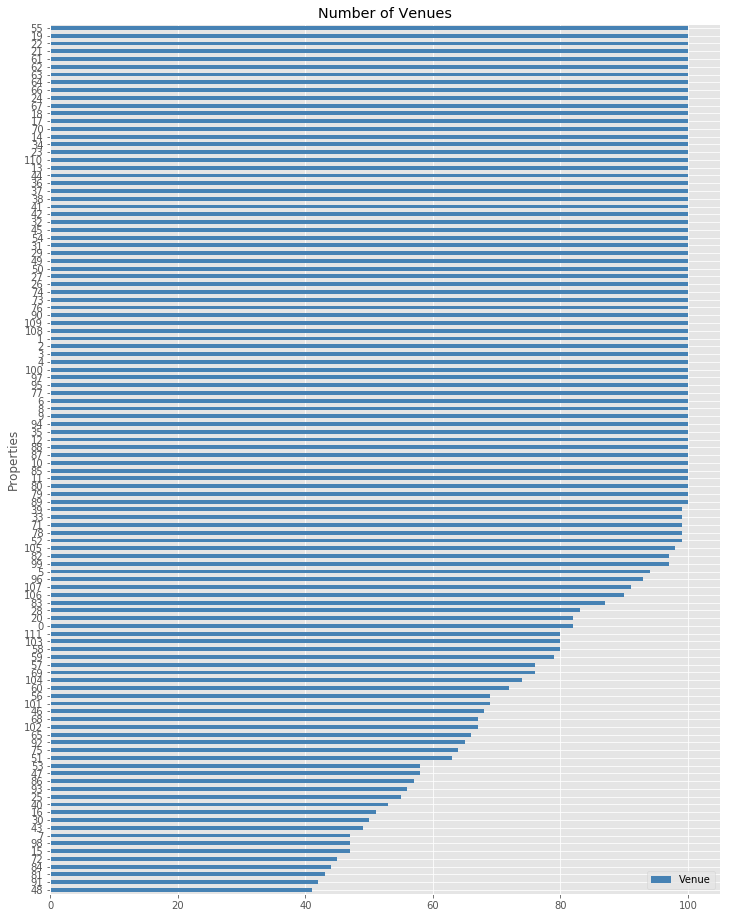

In [40]:
# creat a hbar chart to visualize them
df_bar = df_fit[['Name','Venue']].sort_values('Venue')

df_bar.plot(kind='barh', figsize=(12, 16),color='steelblue')

plt.title("Number of Venues")
plt.ylabel('Properties')

plt.show()

## Let's start to analyze each apartment to dig deeper

In [41]:
array2 = venues_fit['Apartment'].to_list()

df_venues_clean = df_venues.loc[df_venues['Apartment'].isin(array2)].sort_values('Apartment').reset_index(drop=True)
df_venues_clean.head()

,Apartment,Apartment Price,Apartment Latitude,Apartment Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,无锡市万健广场,16000.0,31.613114,120.215703,易捷便利店(钱桥大道店),31.614843,120.217605,购物;便利店
1,无锡市万健广场,16000.0,31.613114,120.215703,克莉丝汀(新兴路店),31.609221,120.222218,美食;蛋糕甜品店
2,无锡市万健广场,16000.0,31.613114,120.215703,青璐蛋糕(钱桥大街店),31.607656,120.221512,美食;蛋糕甜品店
3,无锡市万健广场,16000.0,31.613114,120.215703,食为鲜(钱桥大街店),31.607674,120.220995,美食;中餐厅
4,无锡市万健广场,16000.0,31.613114,120.215703,盈鼎夜宵,31.607837,120.222987,美食;中餐厅


In [42]:
print('df_venues_clean has {} uniques categories.'.format(len(df_venues_clean['Venue Category'].unique())))

df_venues_clean has 70 uniques categories.


In [43]:
venues_onehot = pd.get_dummies(df_venues_clean[['Venue Category']], prefix="", prefix_sep="")

venues_onehot.head(10)

,交通设施;停车场,休闲娱乐;电影院,公交车站,公司企业;公司,出入口;停车场出入口,出入口;门,医疗;专科医院,医疗;其他,医疗;医疗保健,医疗;疗养院,...,购物;百货商场,购物;超市,运动健身;体育场馆,运动健身;健身中心,酒店;其他,酒店;快捷酒店,酒店;星级酒店,金融;atm,金融;信用社,金融;银行
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# one hot encoding
venues_onehot = pd.get_dummies(df_venues_clean[['Venue Category']], prefix="", prefix_sep="")
# Since all these columns are displayed in Chinese and I'll translate them
# into English one by one to match SquareAPI(I'll never use BaiduAPI again:( )

venues_onehot.columns=['Parking','Movie Theater','Bus Stop','Company','Parking Entry','Entry',
                       'Specialist Hospital', 'Medical Other','Medical Healthcare', 'Medical Sanatorium',
                       'General Hospital', 'Medical Clinic','Real Estate','Residential Building (Apartment/Condo)',
                       'Real Estate Other', 'Assisted Living','Business Center', 'Real Estate Dormitory',
                       'Government Public Security&Law Agency','Government Political Education Institution',
                       'Government Social Groups','Government Welfare Institution', 
                       'Government Administrative Institution', 'Education Training','Middle School',
                       'Education Training Other','Elementary School','Primary School','Preschool',
                       'Adult Education Center','Special Education School', 'Scientific Research Institution',
                       'General College & University', 'Cultural Center','Park', 'Park Other', 'Historic Site',
                       'Theme Park Ride/Attraction','Botanical Garden','Health&Beauty Service','Pet Service',
                       'Transportation Service','Post Office', 'Food Service','Chinese Restaurant', 'Food Other',
                       'Café', 'Foreign Restaurant', 'Fast Food Restaurant','Tea Room','Dessert Shop','Bar',
                       'Administrative Landmark','Shopping','Convenience Store','Shopping Mall',
                       'Construction & Landscaping', 'Electronics Store', 'Market', 'Shopping Plaza', 
                       'Shopping Center','Supermarket','Sports Stadium','Gym/Fitness Center','Hotel Inn','Hostel',
                       'Star Hotel','ATM','Credit Union','Bank']
venues_onehot.head()

,Parking,Movie Theater,Bus Stop,Company,Parking Entry,Entry,Specialist Hospital,Medical Other,Medical Healthcare,Medical Sanatorium,...,Shopping Center,Supermarket,Sports Stadium,Gym/Fitness Center,Hotel Inn,Hostel,Star Hotel,ATM,Credit Union,Bank
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# add apartment column back to dataframe
venues_onehot['Apartment'] = df_venues_clean['Apartment']
venues_onehot.head()

,Parking,Movie Theater,Bus Stop,Company,Parking Entry,Entry,Specialist Hospital,Medical Other,Medical Healthcare,Medical Sanatorium,...,Supermarket,Sports Stadium,Gym/Fitness Center,Hotel Inn,Hostel,Star Hotel,ATM,Credit Union,Bank,Apartment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,无锡市万健广场
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,无锡市万健广场
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,无锡市万健广场
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,无锡市万健广场
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,无锡市万健广场


In [46]:
# move name column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])

venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,Apartment,Parking,Movie Theater,Bus Stop,Company,Parking Entry,Entry,Specialist Hospital,Medical Other,Medical Healthcare,...,Shopping Center,Supermarket,Sports Stadium,Gym/Fitness Center,Hotel Inn,Hostel,Star Hotel,ATM,Credit Union,Bank
0,无锡市万健广场,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,无锡市万健广场,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,无锡市万健广场,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,无锡市万健广场,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,无锡市万健广场,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by Apartments and by taking the mean of the frequency of occurrence of each category

In [47]:
venues_grouped = venues_onehot.groupby('Apartment').mean().reset_index()
venues_grouped.head()

,Apartment,Parking,Movie Theater,Bus Stop,Company,Parking Entry,Entry,Specialist Hospital,Medical Other,Medical Healthcare,...,Shopping Center,Supermarket,Sports Stadium,Gym/Fitness Center,Hotel Inn,Hostel,Star Hotel,ATM,Credit Union,Bank
0,无锡市万健广场,0.0,0.0,0.146341,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.097561,0.0,0.0,0.0,0.0,0.0,0.02439,0.0,0.036585
1,无锡市万科北门塘上,0.0,0.0,0.090000,0.0,0.0,0.02,0.0,0.03,0.0,...,0.0,0.150000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000
2,无锡市万科吴都路地块,0.0,0.0,0.120000,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.080000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000
3,无锡市万科天一新著,0.0,0.0,0.120000,0.0,0.0,0.02,0.0,0.00,0.0,...,0.0,0.190000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000
4,无锡市万科天一玖著,0.0,0.0,0.120000,0.0,0.0,0.02,0.0,0.00,0.0,...,0.0,0.170000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000


In [48]:
# check the size again
venues_grouped.shape

(112, 71)

#### Let's print each apartment along with the top 5 most common venues

In [49]:
num_top_venues = 5

for item in venues_grouped['Apartment']:
    print("*******"+item+"*******")
    temp = venues_grouped[venues_grouped['Apartment'] == item].T.reset_index()
    temp.columns = ['venues','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

*******无锡市万健广场*******
                 venues  freq
0    Chinese Restaurant  0.32
1  Fast Food Restaurant  0.18
2              Bus Stop  0.15
3           Supermarket  0.10
4     Convenience Store  0.05


*******无锡市万科北门塘上*******
                 venues  freq
0    Chinese Restaurant  0.22
1  Fast Food Restaurant  0.21
2           Supermarket  0.15
3              Bus Stop  0.09
4        Medical Clinic  0.05


*******无锡市万科吴都路地块*******
                     venues  freq
0      Fast Food Restaurant  0.24
1        Chinese Restaurant  0.22
2                  Bus Stop  0.12
3               Supermarket  0.08
4  Education Training Other  0.07


*******无锡市万科天一新著*******
                 venues  freq
0  Fast Food Restaurant  0.23
1           Supermarket  0.19
2    Chinese Restaurant  0.18
3              Bus Stop  0.12
4          Dessert Shop  0.05


*******无锡市万科天一玖著*******
                 venues  freq
0    Chinese Restaurant  0.20
1  Fast Food Restaurant  0.19
2           Supermarket  0.17
3        

                 venues  freq
0  Fast Food Restaurant  0.23
1    Chinese Restaurant  0.17
2           Supermarket  0.13
3              Bus Stop  0.11
4     Convenience Store  0.05


*******无锡市太湖雍华府*******
                         venues  freq
0                      Bus Stop  0.37
1            Chinese Restaurant  0.12
2                 Middle School  0.06
3  General College & University  0.06
4                         Entry  0.06


*******无锡市家乐府*******
                 venues  freq
0    Chinese Restaurant  0.28
1  Fast Food Restaurant  0.16
2           Supermarket  0.13
3     Convenience Store  0.09
4             Preschool  0.05


*******无锡市家乐苑*******
                 venues  freq
0    Chinese Restaurant  0.28
1  Fast Food Restaurant  0.16
2           Supermarket  0.13
3     Convenience Store  0.09
4             Preschool  0.05


*******无锡市寰宇中心*******
                 venues  freq
0    Chinese Restaurant  0.29
1  Fast Food Restaurant  0.28
2           Supermarket  0.12
3     Convenience

                 venues  freq
0    Chinese Restaurant  0.24
1  Fast Food Restaurant  0.21
2              Bus Stop  0.17
3           Supermarket  0.07
4     Convenience Store  0.06


*******无锡市苏宁悦城*******
                 venues  freq
0              Bus Stop  0.27
1           Supermarket  0.16
2     Convenience Store  0.09
3  Fast Food Restaurant  0.07
4                  Bank  0.05


*******无锡市茂业时代广场*******
               venues  freq
0  Chinese Restaurant  0.30
1         Supermarket  0.25
2   Convenience Store  0.18
3  Foreign Restaurant  0.07
4                Park  0.05


*******无锡市荷兰岛郁金香庄园*******
                 venues  freq
0              Bus Stop  0.28
1  Fast Food Restaurant  0.18
2           Supermarket  0.16
3    Chinese Restaurant  0.14
4              Tea Room  0.09


*******无锡市蓝城无锡江南里*******
                       venues  freq
0          Chinese Restaurant  0.31
1                 Supermarket  0.21
2        Fast Food Restaurant  0.15
3           Convenience Store  0.14
4  Cons

In [50]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [51]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Apartment']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
apartment_venues_sorted = pd.DataFrame(columns=columns)
apartment_venues_sorted['Apartment'] = venues_grouped['Apartment']

for ind in np.arange(venues_grouped.shape[0]):
    apartment_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

apartment_venues_sorted.head()

,Apartment,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,无锡市万健广场,Chinese Restaurant,Fast Food Restaurant,Bus Stop,Supermarket,Convenience Store,Bank,Dessert Shop,ATM,Food Service,Food Other
1,无锡市万科北门塘上,Chinese Restaurant,Fast Food Restaurant,Supermarket,Bus Stop,Convenience Store,Medical Clinic,Pet Service,Medical Other,Foreign Restaurant,Dessert Shop
2,无锡市万科吴都路地块,Fast Food Restaurant,Chinese Restaurant,Bus Stop,Supermarket,Education Training Other,General College & University,Convenience Store,Dessert Shop,Medical Clinic,Preschool
3,无锡市万科天一新著,Fast Food Restaurant,Supermarket,Chinese Restaurant,Bus Stop,Dessert Shop,Preschool,Food Other,Medical Clinic,Construction & Landscaping,Middle School
4,无锡市万科天一玖著,Chinese Restaurant,Fast Food Restaurant,Supermarket,Bus Stop,Dessert Shop,Food Other,Construction & Landscaping,Primary School,Medical Clinic,Preschool


### Try to classfiy these apartments and Run k-means to cluster the neighborhood into 5 clusters

In [52]:
# set number of clusters first
kclusters = 5

wuxi_grouped_clustering = venues_grouped.drop('Apartment', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(wuxi_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50] 

array([1, 4, 4, 4, 4, 4, 3, 4, 0, 0, 3, 3, 0, 3, 4, 4, 4, 0, 0, 3, 4, 3,
       0, 3, 4, 4, 4, 0, 1, 1, 4, 3, 0, 3, 3, 4, 3, 0, 4, 1, 2, 3, 4, 2,
       3, 3, 1, 1, 2, 3], dtype=int32)

In [53]:
# add clustering labels
apartment_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

apartment_merged = data_fit

# merge apartment_grouped with apartment_data to add latitude/longitude for each apartment
apartment_merged = apartment_merged.join(apartment_venues_sorted.set_index('Apartment'), on='Apartment')

apartment_merged.head() # check the last columns!

,Apartment,Price,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,无锡市万健广场,16000.0,31.613114,120.215703,1,Chinese Restaurant,Fast Food Restaurant,Bus Stop,Supermarket,Convenience Store,Bank,Dessert Shop,ATM,Food Service,Food Other
1,无锡市万科北门塘上,17500.0,31.614681,120.294482,4,Chinese Restaurant,Fast Food Restaurant,Supermarket,Bus Stop,Convenience Store,Medical Clinic,Pet Service,Medical Other,Foreign Restaurant,Dessert Shop
2,无锡市万科吴都路地块,15972.5,31.484508,120.290816,4,Fast Food Restaurant,Chinese Restaurant,Bus Stop,Supermarket,Education Training Other,General College & University,Convenience Store,Dessert Shop,Medical Clinic,Preschool
3,无锡市万科天一新著,16000.0,31.648087,120.305770,4,Fast Food Restaurant,Supermarket,Chinese Restaurant,Bus Stop,Dessert Shop,Preschool,Food Other,Medical Clinic,Construction & Landscaping,Middle School
4,无锡市万科天一玖著,17000.0,31.646859,120.304601,4,Chinese Restaurant,Fast Food Restaurant,Supermarket,Bus Stop,Dessert Shop,Food Other,Construction & Landscaping,Primary School,Medical Clinic,Preschool


In [56]:
apartment_merged.groupby('1st Most Common Venue').count()

,Apartment,Price,Latitude,Longitude,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1st Most Common Venue,,,,,,,,,,,,,,
Bus Stop,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Chinese Restaurant,65,65,65,65,65,65,65,65,65,65,65,65,65,65
Fast Food Restaurant,30,30,30,30,30,30,30,30,30,30,30,30,30,30
Supermarket,7,7,7,7,7,7,7,7,7,7,7,7,7,7


In [57]:
apartment_merged.groupby('2nd Most Common Venue').count()

,Apartment,Price,Latitude,Longitude,Cluster Labels,1st Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2nd Most Common Venue,,,,,,,,,,,,,,
Bank,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Bus Stop,9,9,9,9,9,9,9,9,9,9,9,9,9,9
Chinese Restaurant,27,27,27,27,27,27,27,27,27,27,27,27,27,27
Convenience Store,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Education Training Other,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Fast Food Restaurant,41,41,41,41,41,41,41,41,41,41,41,41,41,41
Supermarket,32,32,32,32,32,32,32,32,32,32,32,32,32,32


In [58]:
apartment_merged.groupby('3rd Most Common Venue').count()

,Apartment,Price,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3rd Most Common Venue,,,,,,,,,,,,,,
ATM,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Bus Stop,20,20,20,20,20,20,20,20,20,20,20,20,20,20
Chinese Restaurant,13,13,13,13,13,13,13,13,13,13,13,13,13,13
Convenience Store,15,15,15,15,15,15,15,15,15,15,15,15,15,15
Fast Food Restaurant,23,23,23,23,23,23,23,23,23,23,23,23,23,23
General College & University,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Medical Clinic,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Supermarket,37,37,37,37,37,37,37,37,37,37,37,37,37,37


#### The top three veunes of these apartment are 'Chinese Restaurant	','Fast Food Restaurant','Supermarket'

#### "Let's creat a map and make these apartments with different groups with different colors"

In [54]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(apartment_merged['Latitude'], apartment_merged['Longitude'], apartment_merged['Apartment'], apartment_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [55]:
apartment_merged.loc[apartment_merged['Cluster Labels'] == 0, 
                     apartment_merged.columns[[0,1] + list(range(5, apartment_merged.shape[1]))]]

,Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,15972.5,Chinese Restaurant,Supermarket,Fast Food Restaurant,Convenience Store,Construction & Landscaping,Park,Foreign Restaurant,Theme Park Ride/Attraction,Food Other,Shopping Plaza
9,15972.5,Chinese Restaurant,Supermarket,Convenience Store,Fast Food Restaurant,Park,Foreign Restaurant,Construction & Landscaping,Shopping Plaza,Food Service,Shopping
12,15972.5,Supermarket,Chinese Restaurant,Convenience Store,Foreign Restaurant,Park,Fast Food Restaurant,Construction & Landscaping,Hotel Inn,Dessert Shop,Theme Park Ride/Attraction
17,15972.5,Chinese Restaurant,Supermarket,Convenience Store,Fast Food Restaurant,Construction & Landscaping,Middle School,Foreign Restaurant,Primary School,Dessert Shop,Park
18,17500.0,Chinese Restaurant,Supermarket,Fast Food Restaurant,Convenience Store,Primary School,Preschool,Foreign Restaurant,Food Other,Construction & Landscaping,Dessert Shop
22,15972.5,Chinese Restaurant,Supermarket,Convenience Store,Park,Foreign Restaurant,Construction & Landscaping,Theme Park Ride/Attraction,Fast Food Restaurant,Shopping Plaza,Food Other
27,15972.5,Chinese Restaurant,Supermarket,Convenience Store,Fast Food Restaurant,Foreign Restaurant,Dessert Shop,Construction & Landscaping,Shopping Plaza,Food Other,Park
32,15972.5,Chinese Restaurant,Supermarket,Convenience Store,Fast Food Restaurant,Medical Clinic,Construction & Landscaping,Preschool,Bus Stop,Medical Other,Food Other
37,15972.5,Supermarket,Chinese Restaurant,Fast Food Restaurant,Construction & Landscaping,Convenience Store,Park,Foreign Restaurant,Government Welfare Institution,Café,Food Service
50,15972.5,Chinese Restaurant,Convenience Store,Supermarket,Construction & Landscaping,Fast Food Restaurant,Foreign Restaurant,Park,Shopping Plaza,Dessert Shop,Shopping Mall


In [62]:
apartment_merged.loc[apartment_merged['Cluster Labels'] == 1, 
                     apartment_merged.columns[[0,1] + list(range(5, apartment_merged.shape[1]))]]

,Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,16000.0,Chinese Restaurant,Fast Food Restaurant,Bus Stop,Supermarket,Convenience Store,Bank,Dessert Shop,ATM,Food Service,Food Other
28,16000.0,Chinese Restaurant,Supermarket,Fast Food Restaurant,Bus Stop,Dessert Shop,Foreign Restaurant,Convenience Store,Food Other,Construction & Landscaping,Café
29,15972.5,Chinese Restaurant,Fast Food Restaurant,Bus Stop,Supermarket,Convenience Store,Medical Clinic,Construction & Landscaping,Foreign Restaurant,Medical Other,Middle School
39,15000.0,Chinese Restaurant,Fast Food Restaurant,ATM,Supermarket,Bank,Convenience Store,Bus Stop,Medical Clinic,Primary School,Entry
46,15972.5,Chinese Restaurant,Fast Food Restaurant,Supermarket,Bus Stop,Convenience Store,Bank,ATM,Preschool,Food Other,Construction & Landscaping
47,17500.0,Chinese Restaurant,Fast Food Restaurant,Supermarket,Bus Stop,Preschool,Elementary School,Construction & Landscaping,Convenience Store,Food Other,Tea Room
51,15972.5,Chinese Restaurant,Fast Food Restaurant,Supermarket,Bus Stop,Medical Clinic,Tea Room,Dessert Shop,Convenience Store,Preschool,Food Other
58,15972.5,Chinese Restaurant,Fast Food Restaurant,Supermarket,Convenience Store,Preschool,Construction & Landscaping,Food Other,Foreign Restaurant,Dessert Shop,Elementary School
59,15972.5,Chinese Restaurant,Fast Food Restaurant,Bus Stop,Supermarket,Dessert Shop,Convenience Store,Foreign Restaurant,Medical Other,Food Other,Bank
69,15972.5,Chinese Restaurant,Fast Food Restaurant,Bus Stop,Supermarket,Dessert Shop,Food Other,Foreign Restaurant,Convenience Store,Construction & Landscaping,Bank


In [63]:
apartment_merged.loc[apartment_merged['Cluster Labels'] == 2, 
                     apartment_merged.columns[[0,1] + list(range(5, apartment_merged.shape[1]))]]

,Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,15972.5,Bus Stop,Education Training Other,Chinese Restaurant,Convenience Store,Entry,Dessert Shop,Fast Food Restaurant,General College & University,Supermarket,Foreign Restaurant
43,15972.5,Bus Stop,Chinese Restaurant,General College & University,Middle School,Entry,Dessert Shop,Fast Food Restaurant,Education Training Other,Café,Scientific Research Institution
48,17000.0,Bus Stop,Supermarket,Convenience Store,Fast Food Restaurant,Dessert Shop,Preschool,Tea Room,Primary School,Elementary School,Middle School
65,15972.5,Bus Stop,Bank,ATM,Chinese Restaurant,Dessert Shop,Foreign Restaurant,Food Service,Café,Tea Room,Fast Food Restaurant
84,15972.5,Bus Stop,Supermarket,Convenience Store,Fast Food Restaurant,Bank,Preschool,Tea Room,Dessert Shop,Park,Parking
86,15972.5,Bus Stop,Fast Food Restaurant,Supermarket,Chinese Restaurant,Tea Room,Convenience Store,Medical Clinic,Park,Construction & Landscaping,Preschool
92,15500.0,Supermarket,Bus Stop,Fast Food Restaurant,Dessert Shop,Convenience Store,Preschool,Food Service,Chinese Restaurant,Primary School,Entry
98,15972.5,Bus Stop,Supermarket,Convenience Store,Fast Food Restaurant,Bank,Dessert Shop,Preschool,Tea Room,Parking Entry,Entry


In [79]:
fav = apartment_merged.loc[apartment_merged['Cluster Labels'] == 3, 
                     apartment_merged.columns[[0,1,2,3] + list(range(5, apartment_merged.shape[1]))]].sort_values('Price')
fav.head()

,Apartment,Price,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
49,无锡市康诗丹郡,14800.0,31.577184,120.346260,Fast Food Restaurant,Supermarket,Chinese Restaurant,Convenience Store,Preschool,Elementary School,Foreign Restaurant,Medical Other,Pet Service,Food Other
44,无锡市家乐府,14900.0,31.557940,120.305213,Chinese Restaurant,Fast Food Restaurant,Supermarket,Convenience Store,Construction & Landscaping,Preschool,Elementary School,Park,Food Other,Foreign Restaurant
45,无锡市家乐苑,15000.0,31.557940,120.305213,Chinese Restaurant,Fast Food Restaurant,Supermarket,Convenience Store,Construction & Landscaping,Preschool,Elementary School,Park,Food Other,Foreign Restaurant
88,无锡市融创大塘御园,15972.5,31.609446,120.295719,Chinese Restaurant,Supermarket,Fast Food Restaurant,Convenience Store,Construction & Landscaping,Preschool,Foreign Restaurant,Medical Other,General Hospital,Primary School
78,无锡市绿地中央广场,15972.5,31.572273,120.349833,Supermarket,Chinese Restaurant,Fast Food Restaurant,Convenience Store,Construction & Landscaping,Food Other,Preschool,Primary School,Foreign Restaurant,Real Estate Other


In [70]:
apartment_merged.loc[apartment_merged['Cluster Labels'] == 4, 
                     apartment_merged.columns[[0,1] + list(range(5, apartment_merged.shape[1]))]]

,Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,17500.0,Chinese Restaurant,Fast Food Restaurant,Supermarket,Bus Stop,Convenience Store,Medical Clinic,Pet Service,Medical Other,Foreign Restaurant,Dessert Shop
2,15972.5,Fast Food Restaurant,Chinese Restaurant,Bus Stop,Supermarket,Education Training Other,General College & University,Convenience Store,Dessert Shop,Medical Clinic,Preschool
3,16000.0,Fast Food Restaurant,Supermarket,Chinese Restaurant,Bus Stop,Dessert Shop,Preschool,Food Other,Medical Clinic,Construction & Landscaping,Middle School
4,17000.0,Chinese Restaurant,Fast Food Restaurant,Supermarket,Bus Stop,Dessert Shop,Food Other,Construction & Landscaping,Primary School,Medical Clinic,Preschool
5,15000.0,Chinese Restaurant,Fast Food Restaurant,Supermarket,Bus Stop,Dessert Shop,Foreign Restaurant,Convenience Store,Construction & Landscaping,Medical Clinic,Preschool
7,17000.0,Fast Food Restaurant,Chinese Restaurant,Bus Stop,Food Service,Café,Dessert Shop,Entry,Convenience Store,Middle School,Bar
14,15972.5,Chinese Restaurant,Bus Stop,Fast Food Restaurant,Supermarket,Foreign Restaurant,Preschool,Food Other,Dessert Shop,Park,Convenience Store
15,15972.5,Bus Stop,Chinese Restaurant,Fast Food Restaurant,Entry,Dessert Shop,Parking Entry,Middle School,Supermarket,Park,Convenience Store
16,15972.5,Bus Stop,Fast Food Restaurant,Chinese Restaurant,Supermarket,ATM,Convenience Store,Dessert Shop,Bank,Entry,Elementary School
20,15972.5,Chinese Restaurant,Fast Food Restaurant,Bus Stop,Bank,ATM,Foreign Restaurant,Café,Supermarket,Dessert Shop,Convenience Store


In [71]:
len(apartment_merged.loc[apartment_merged['Cluster Labels'] == 3, 
                     apartment_merged.columns[[0,1] + list(range(5, apartment_merged.shape[1]))]].sort_values('Price'))

26

In [ ]:
### visualisation of cluster 3 

In [78]:
# create map of Wuxi using latitude and longitude values
map_fav = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers to map
for lat, lng, apartment in zip(fav['Latitude'], fav['Longitude'], fav['Apartment']):
    label = '{}'.format(apartment)
    folium.Marker(location=[lat,lng],
                  popup=label,
                  icon=folium.Icon(color='steelblue',prefix='fa',icon='circle')).add_to(map_fav)

#   
map_fav

### Thank you!